`TTbarResCoffeaOutputs` Notebook to produce Coffea output files for an all hadronic $t\bar{t}$ analysis, should one choose not to run the .py script with condor.  The outputs will be found in the corresponding **CoffeaOutputs** directory.

In [1]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt

from lpcjobqueue import LPCCondorCluster

/opt/conda/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


### Import processor

In [2]:
from CoffeaJERCProcessor import Processor

In [3]:
xrootdstr = 'root://cmsxrootd.fnal.gov/'

rootfiles = open('dataset.txt').read().split()

fileslist = [xrootdstr + file for file in rootfiles]



In [4]:
fileslist[0]

'root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root'

In [6]:
UsingDaskExecutor = False

if(UsingDaskExecutor):

        cluster = LPCCondorCluster()
        cluster.adapt(minimum=1, maximum=10)
        client = Client(cluster)
        client.upload_file('CoffeaJERCProcessor.py')
        
# client

In [7]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

# xrootdstr = 'root://cmsxrootd.fnal.gov/'
# files = [xrootdstr + "/store/mc/RunIISummer19UL17NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/JMECustomTuples_106X_mc2017_realistic_v6-v1/280000/0F7E67F1-5FCB-EC4B-A0B3-E0E9B98AFC43.root"]
# files = ['JMECustomTuples_106X_mc2017_realistic_v6-v1.root']

filesets = {'QCD': fileslist}

for name,files in filesets.items(): 
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=Chunk[0], maxchunks=Chunk[1])
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':False,
                                              'schema': NanoAODSchema, #BaseSchema
#                                               'workers': 2
                                          },
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])

elapsed = time.time() - tstart
outputs_unweighted[name] = output
print(output)
util.save(output, 'CoffeaJERCOutputs_binned.coffea')


outputs_unweighted[name] = output
print(name + ' unweighted output loaded')
elapsed = time.time() - tstart

Output()

dict_keys(['Summer20_UL18_MC_L1FastJet_AK4PFchs'])
['Summer20_UL18_MC_L1FastJet_AK4PFchs']



Output()

{'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f47da556100>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f47efe24c10>, 'jetpt': <Hist (dataset,pt) instance at 0x7f47da397220>, 'jeteta': <Hist (dataset,jeteta) instance at 0x7f4804437ee0>, 'jetphi': <Hist (dataset,jetphi) instance at 0x7f4804437700>, 'cutflow': defaultdict_accumulator(<class 'int'>, {})}
QCD unweighted output loaded


### Load coffea output file

In [8]:
# output = util.load('CoffeaJERCOutputs_19928000events.coffea')
output = util.load('CoffeaJERCOutputs_binned.coffea')

In [9]:
# define gaussian function
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [10]:
ptbins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 20, 23, 27, 30, 35, 40, 45, 57, 72, 90, 120, 
        150, 200, 300, 400, 550, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000 ]





In [11]:
etabins =   [-4.889,  -4.716,  -4.538,  -4.363,  -4.191,  -4.013,  -3.839,  -3.664,  -3.489,
           -3.314,  -3.139,  -2.964,  -2.853,  -2.65,  -2.5,  -2.322,  -2.172,  -2.043,  -1.93,  -1.83,
           -1.74,  -1.653,  -1.566,  -1.479,  -1.392,  -1.305,  -1.218,  -1.131,  -1.044,  -0.957,  -0.879,
           -0.783,  -0.696,  -0.609,  -0.522,  -0.435,  -0.348,  -0.261,  -0.174,  -0.087,  0,  0.087,  0.174,
           0.261,  0.348,  0.435,  0.522,  0.609,  0.696,  0.783,  0.879,  0.957,  1.044,  1.131,  1.218,
           1.305,  1.392,  1.479,  1.566,  1.653,  1.74,  1.83,  1.93,  2.043,  2.172,  2.322,  2.5,  2.65,
           2.853,  2.964,  3.139,  3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,  4.716,
           4.889, ]#5.191 ]

In [12]:
jetpt_length = len(output['jetpt'].axis('pt')[1:-1])
jeteta_length = len(output['jeteta'].axis('jeteta')[1:-1])
jeteta_length = len(etabins)

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
idx = []

In [13]:
for k in range(len(etabins)-1):
    print(hist.Interval(etabins[k], etabins[k+1]))
print()    
for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    print(etaBin)

[-4.889, -4.716)
[-4.716, -4.538)
[-4.538, -4.363)
[-4.363, -4.191)
[-4.191, -4.013)
[-4.013, -3.839)
[-3.839, -3.664)
[-3.664, -3.489)
[-3.489, -3.314)
[-3.314, -3.139)
[-3.139, -2.964)
[-2.964, -2.853)
[-2.853, -2.65)
[-2.65, -2.5)
[-2.5, -2.322)
[-2.322, -2.172)
[-2.172, -2.043)
[-2.043, -1.93)
[-1.93, -1.83)
[-1.83, -1.74)
[-1.74, -1.653)
[-1.653, -1.566)
[-1.566, -1.479)
[-1.479, -1.392)
[-1.392, -1.305)
[-1.305, -1.218)
[-1.218, -1.131)
[-1.131, -1.044)
[-1.044, -0.957)
[-0.957, -0.879)
[-0.879, -0.783)
[-0.783, -0.696)
[-0.696, -0.609)
[-0.609, -0.522)
[-0.522, -0.435)
[-0.435, -0.348)
[-0.348, -0.261)
[-0.261, -0.174)
[-0.174, -0.087)
[-0.087, 0)
[0, 0.087)
[0.087, 0.174)
[0.174, 0.261)
[0.261, 0.348)
[0.348, 0.435)
[0.435, 0.522)
[0.522, 0.609)
[0.609, 0.696)
[0.696, 0.783)
[0.783, 0.879)
[0.879, 0.957)
[0.957, 1.044)
[1.044, 1.131)
[1.131, 1.218)
[1.218, 1.305)
[1.305, 1.392)
[1.392, 1.479)
[1.479, 1.566)
[1.566, 1.653)
[1.653, 1.74)
[1.74, 1.83)
[1.83, 1.93)
[1.93, 2.043)
[2

In [14]:
xvals = output['ptresponse'].axis('ptresponse').centers()
f_xvals = np.linspace(0,5,5001)

# mean = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# median = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# width = [[]]*len(output['jetpt'].axis('pt')[1:-1])
# idx = []

j = 0

# for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1]):
    
for i in range(len(ptbins)-1):
        
    ptBin = hist.Interval(ptbins[i], ptbins[i+1])
    print('pt bin '+str(ptBin))
    
    if not 'inf' in str(ptBin):
        pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
    else:
        pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
        pt_string = pt_string.replace('.0','').replace('-infto','0to')
    
#     for k, etaBin in enumerate(output['jeteta'].axis('jeteta')[1:-1]):
    for k in range(len(etabins)-1):
        
        etaBin = hist.Interval(etabins[k], etabins[k+1])
        
    
        
        eta_string = '_eta'+str(etaBin.lo)+'to'+str(etaBin.hi)
        eta_string = eta_string.replace('.','')

        
        
        histo = output['ptresponse'].integrate('jeteta', etaBin).integrate('pt', ptBin)
        
        histvals = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

        yvals = histo.values()[('QCD',)]
        
        
        
        try:
            p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        except:
            continue

        
        fgaus = gauss(f_xvals, *p)
        
#         median[i,k] = f_xvals[fgaus == np.max(fgaus)]
        median[i,k] = np.median(histvals)
        mean[i,k] = p[1]
        width[i,k] = p[2]
        idx.append(i)
        
        
        
        

        
        
#         h = np.max(histo.values()[('QCD',)])
#         ax = hist.plot1d(histo, overlay='dataset')
# #         plt.plot(f_xvals, fgaus)
#         plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
#         plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
#         plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))


#         plt.savefig('ptResponse'+pt_string+eta_string+'.png')
#         plt.show()
        


pt bin [1, 2)


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pt bin [2, 3)
pt bin [3, 4)
pt bin [4, 5)
pt bin [5, 6)


/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


pt bin [6, 7)
pt bin [7, 8)
pt bin [8, 9)
pt bin [9, 10)
pt bin [10, 11)
pt bin [11, 12)
pt bin [12, 13)
pt bin [13, 14)
pt bin [14, 15)
pt bin [15, 17)
pt bin [17, 20)
pt bin [20, 23)
pt bin [23, 27)
pt bin [27, 30)
pt bin [30, 35)
pt bin [35, 40)
pt bin [40, 45)
pt bin [45, 57)
pt bin [57, 72)
pt bin [72, 90)
pt bin [90, 120)
pt bin [120, 150)
pt bin [150, 200)
pt bin [200, 300)
pt bin [300, 400)
pt bin [400, 550)
pt bin [550, 750)
pt bin [750, 1000)
pt bin [1000, 1500)
pt bin [1500, 2000)
pt bin [2000, 2500)
pt bin [2500, 3000)
pt bin [3000, 3500)
pt bin [3500, 4000)
pt bin [4000, 4500)
pt bin [4500, 5000)
pt bin [5000, 10000)


In [15]:
histo = output['ptresponse'].integrate('jeteta', hist.Interval(-0.5, 0)).integrate('pt', hist.Interval(180, 200))

histo.values()

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=jeteta) instance at 0x7f480a5259a0>: requested start -0.5 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:638: RuntimeWarning: Reducing along axis <Bin (name=pt) instance at 0x7f480a725580>: requested start 180.0 between bin boundaries, no interpolation is performed
  warnings.warn(


{('QCD',): array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   6.,  22.,  44.,  98., 130., 124.,  73.,  31.,
          3.,   6.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.])}

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


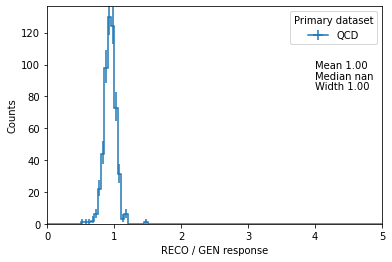

In [16]:
        h = np.max(histo.values()[('QCD',)])
        ax = hist.plot1d(histo, overlay='dataset')
#         plt.plot(f_xvals, fgaus)
        plt.savefig('ptResponse'+pt_string+eta_string+'.png')
        plt.text(4,0.75*h,'Mean {0:0.2f}'.format(p[1]))
        plt.text(4,0.7*h,'Median {0:0.2f}'.format(np.median(histvals)))
        plt.text(4,0.65*h,'Width {0:0.2f}'.format(p[2]))

        plt.show()

In [17]:
14000/h

107.6923076923077

In [18]:
np.max(histo.values()[('QCD',)])

130.0

In [19]:
arr = np.repeat(histo.axis('ptresponse').centers(), np.array(histo.values()[('QCD',)],dtype='int'))

In [20]:
np.array(histo.values()[('QCD',)],dtype='int')

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,
         2,   6,  22,  44,  98, 130, 124,  73,  31,   3,   6,   0,   0,
         0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [22]:
# data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data = {str(ptBin):mean[i] for i, ptBin in enumerate(ptbins)}

# data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data['etaBins'] = [str(etaBin) for etaBin in etabins]

df = pd.DataFrame(data=data)
df = df.set_index('etaBins')
df.to_csv('EtaBinsvsPtBinsMean.csv')

In [24]:
# data_width = {str(ptBin):width[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_width = {str(ptBin):width[i] for i, ptBin in enumerate(ptbins)}

# data_width['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_width['etaBins'] = [str(etaBin) for etaBin in etabins]

df_width = pd.DataFrame(data=data_width)
df_width = df_width.set_index('etaBins')
df_width.to_csv('EtaBinsvsPtBinsWidth.csv')

In [25]:
# data_median = {str(ptBin):median[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
data_median = {str(ptBin):median[i] for i, ptBin in enumerate(ptbins)}

# data_median['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
data_median['etaBins'] = [str(etaBin) for etaBin in etabins]

df_median = pd.DataFrame(data=data_median)
df_median = df_median.set_index('etaBins')
df_median.to_csv('EtaBinsvsPtBinsMedian.csv')

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

           1    2         3         4         5         6         7         8  \
etaBins                                                                         
-4.889   1.0  1.0  1.000000  1.000000  0.000000  1.000000  1.000000  1.000000   
-4.716   1.0  1.0  1.000000  0.000000  1.000000  1.000000  0.925049  0.976075   
-4.538   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.976075  0.750000   
-4.363   1.0  1.0  1.000000  1.000000  1.000000  1.000000  1.274597  0.750000   
-4.191   1.0  1.0  1.000000  1.000000  1.000000  1.000000  1.000000  0.000000   
-4.013   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.976075  0.977154   
-3.839   1.0  1.0  1.000000  1.000000  1.725000  0.000000  1.224830  0.999812   
-3.664   1.0  1.0  1.000000  1.000000  2.375038  0.000000  0.976075  1.124992   
-3.489   1.0  1.0  1.000000  1.000000  1.000000  1.000000  0.686810  0.643416   
-3.314   1.0  1.0  1.000000  1.000000  1.824536 -1.825562  0.375000  1.000000   
-3.139   1.0  1.0  1.000000 

In [27]:
df

,1,2,3,4,5,6,7,8,9,10,...,1000,1500,2000,2500,3000,3500,4000,4500,5000,10000
etaBins,,,,,,,,,,,,,,,,,,,,,
-4.889,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.824102,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.716,1.0,1.0,1.0,0.0,1.0,1.0,0.925049,0.976075,0.577792,1.375007,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.538,1.0,1.0,1.0,1.0,1.0,1.0,0.976075,0.750000,0.775000,0.522654,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.363,1.0,1.0,1.0,1.0,1.0,1.0,1.274597,0.750000,0.000000,0.875000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.191,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.025000,0.810110,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.191,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.923901,0.825135,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.363,1.0,1.0,1.0,1.0,1.0,1.0,-0.548518,0.625000,0.000000,0.522583,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.538,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.675000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [28]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', np.round(df[ptBin][etaBin],3))
print('median =', np.round(df_median[ptBin][etaBin],3))
print('width  =', np.round(df_width[ptBin][etaBin],3))

mean   = 0.928
median = 0.925
width  = 0.069


In [29]:
# df[pt bin][eta bin]

ptBin = '300'
etaBin = '0.783'

print('mean   =', df[ptBin][etaBin])
print('median =', df_median[ptBin][etaBin])
print('width  =', df_width[ptBin][etaBin])

mean   = 0.9282251978096374
median = 0.925
width  = 0.06907679747677807


### Read csv


 

format for example $ 20 \text{ GeV} < p_T < 25 \text{ GeV} $ and $ 3.5 < \eta < 4.0 $


```
df = pd.read_csv('EtaBinsvsPtBinsMean.csv).set_index('etaBins')
ptBin='[20, 25)'
etaBin='[3.5, 4)'
mean = df[ptBin][etaBin]
```




In [30]:
df_csv = pd.read_csv('EtaBinsvsPtBinsMean.csv').set_index('etaBins')

In [31]:
df_csv

,1,2,3,4,5,6,7,8,9,10,...,1000,1500,2000,2500,3000,3500,4000,4500,5000,10000
etaBins,,,,,,,,,,,,,,,,,,,,,
-4.889,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,1.000000,0.824102,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.716,1.0,1.0,1.0,0.0,1.0,1.0,0.925049,0.976075,0.577792,1.375007,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.538,1.0,1.0,1.0,1.0,1.0,1.0,0.976075,0.750000,0.775000,0.522654,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.363,1.0,1.0,1.0,1.0,1.0,1.0,1.274597,0.750000,0.000000,0.875000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
-4.191,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,1.025000,0.810110,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.191,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.000000,0.923901,0.825135,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.363,1.0,1.0,1.0,1.0,1.0,1.0,-0.548518,0.625000,0.000000,0.522583,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4.538,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.675000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [32]:
df_median

,1,2,3,4,5,6,7,8,9,10,...,1000,1500,2000,2500,3000,3500,4000,4500,5000,10000
etaBins,,,,,,,,,,,,,,,,,,,,,
-4.889,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.825,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
-4.716,NaN,NaN,NaN,0.0,NaN,NaN,0.975,0.975,0.675,1.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
-4.538,NaN,NaN,NaN,NaN,NaN,NaN,0.975,0.750,0.775,0.525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
-4.363,NaN,NaN,NaN,NaN,NaN,NaN,1.200,0.925,0.000,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
-4.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.025,0.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.191,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.925,0.825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4.363,NaN,NaN,NaN,NaN,NaN,NaN,0.675,0.850,0.000,0.525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4.538,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [33]:
eff = np.random.rand(10,10)
ptbins = np.random.randint(9, size=10)
etabins = np.random.randint(9, size=10)